In [1]:
import clip
import numpy as np
import torch

import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch
from torchvision.datasets import CIFAR100

# CLIP

In [2]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def _convert_image_to_rgb(image):
    return image.convert("RGB")

original_images = []
images = []
texts = []

descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

# Calculating cosine similarity

Text(0.5, 1.0, 'Cosine similarity between text and image features')

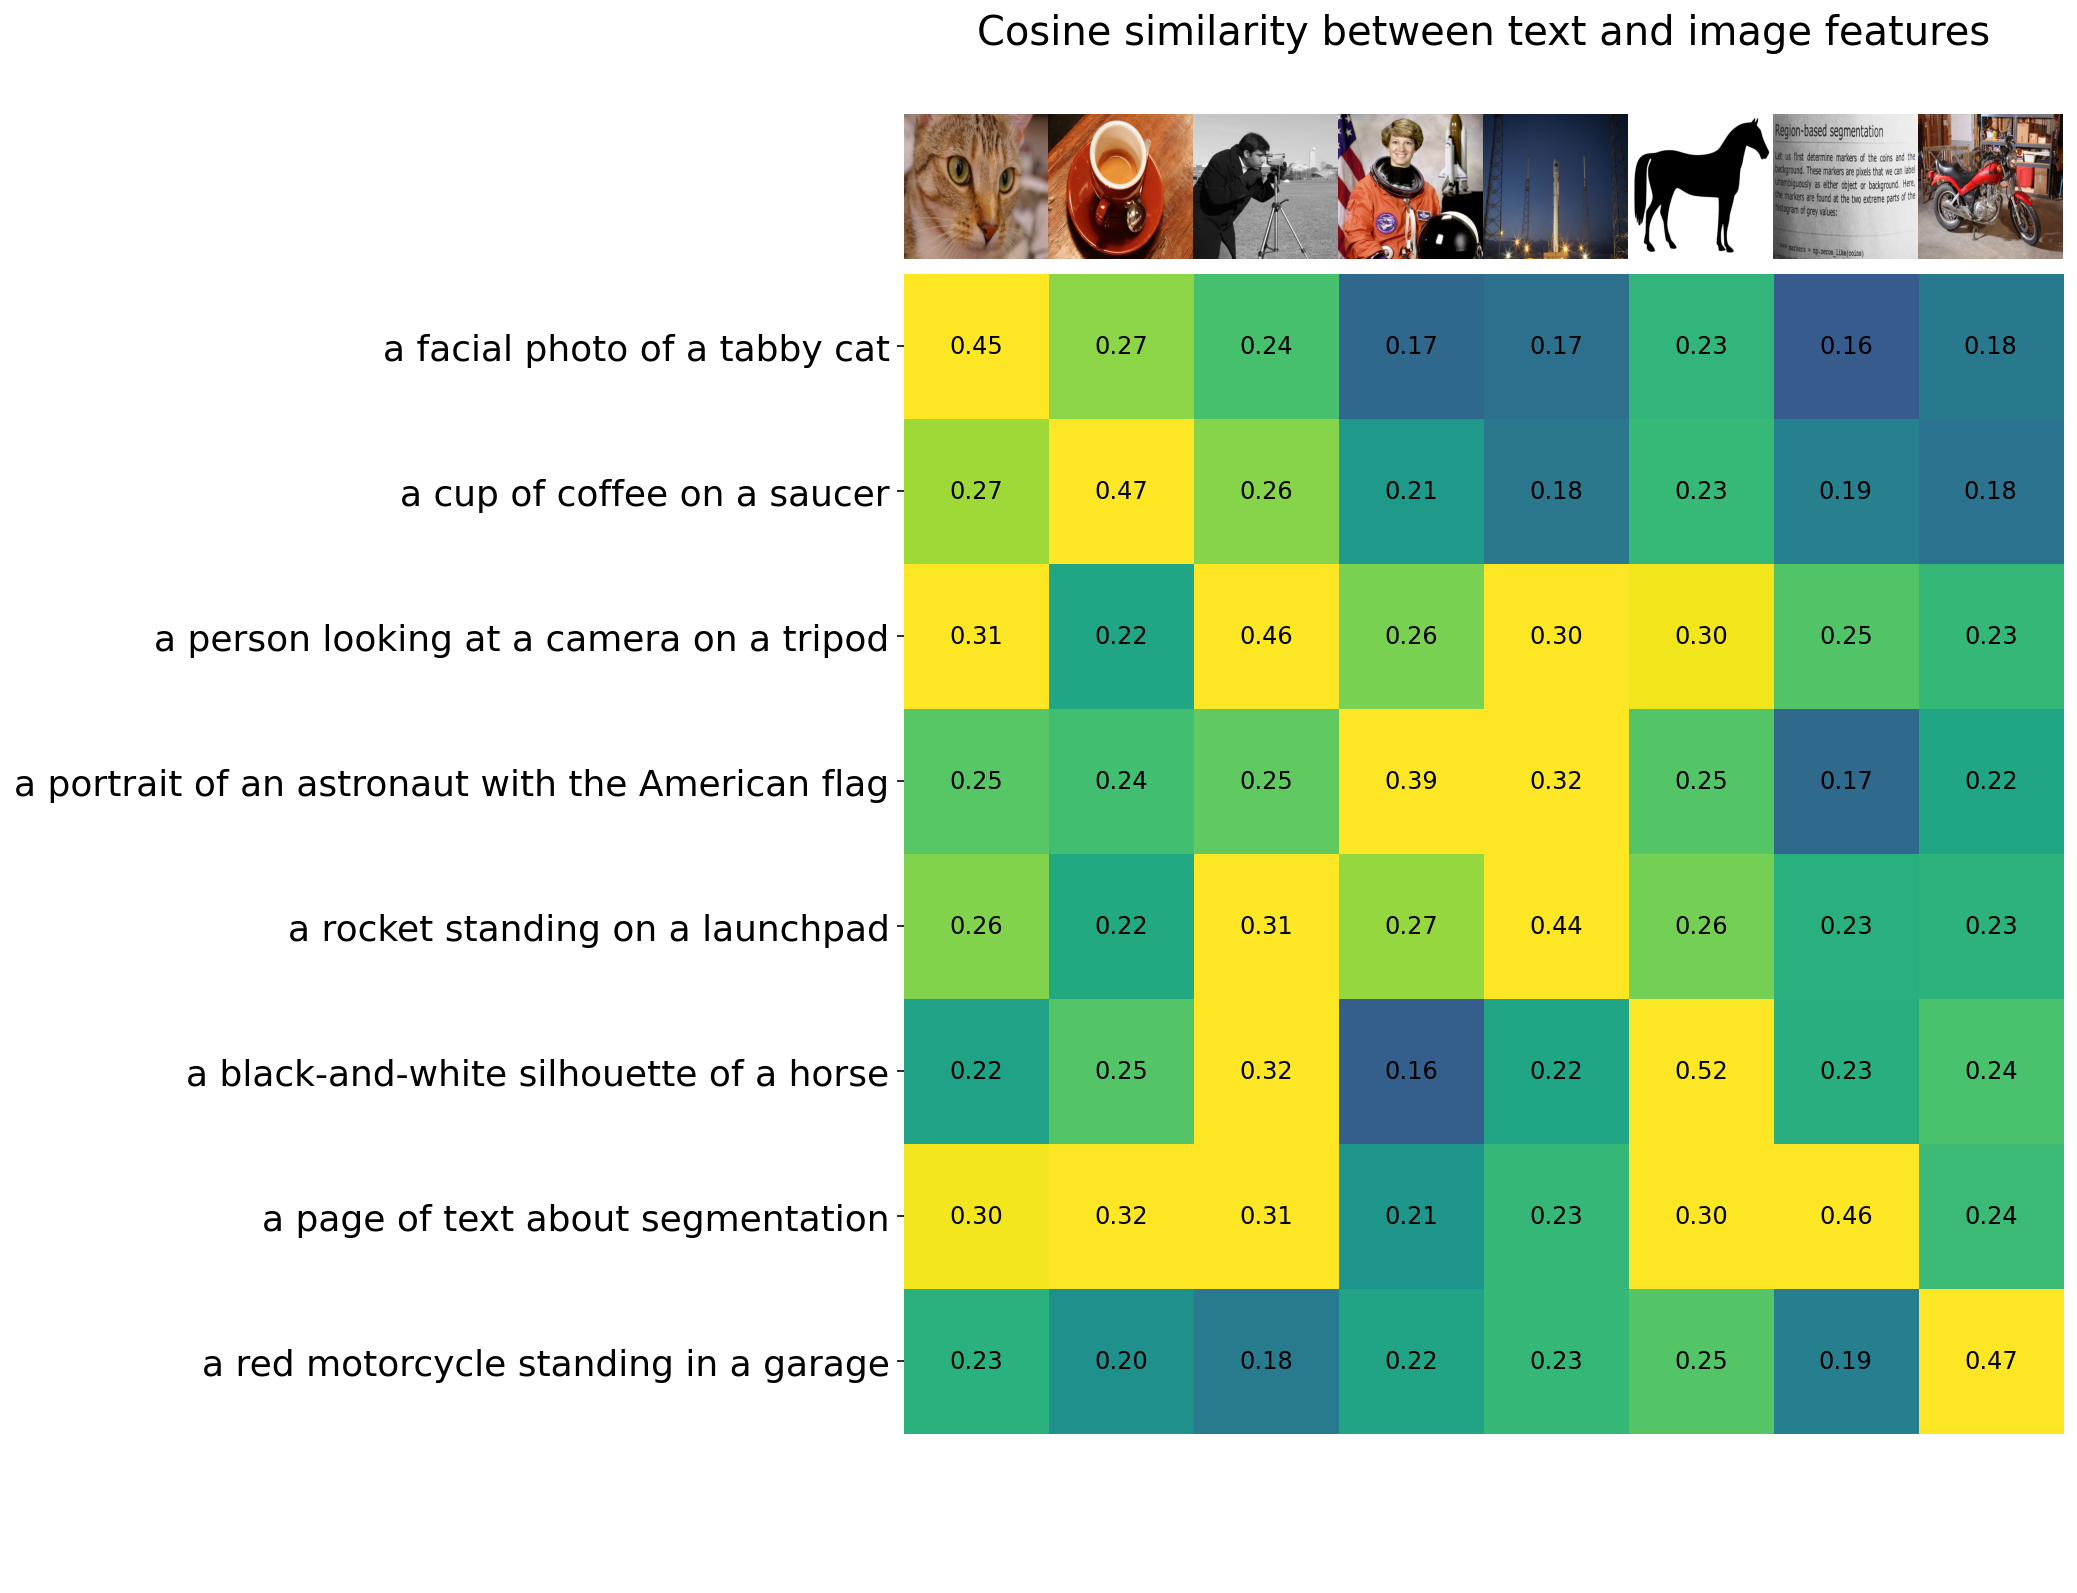

In [4]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()
_, similarity = model(image_input, text_tokens)
similarity = similarity.cpu().detach().numpy() 
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


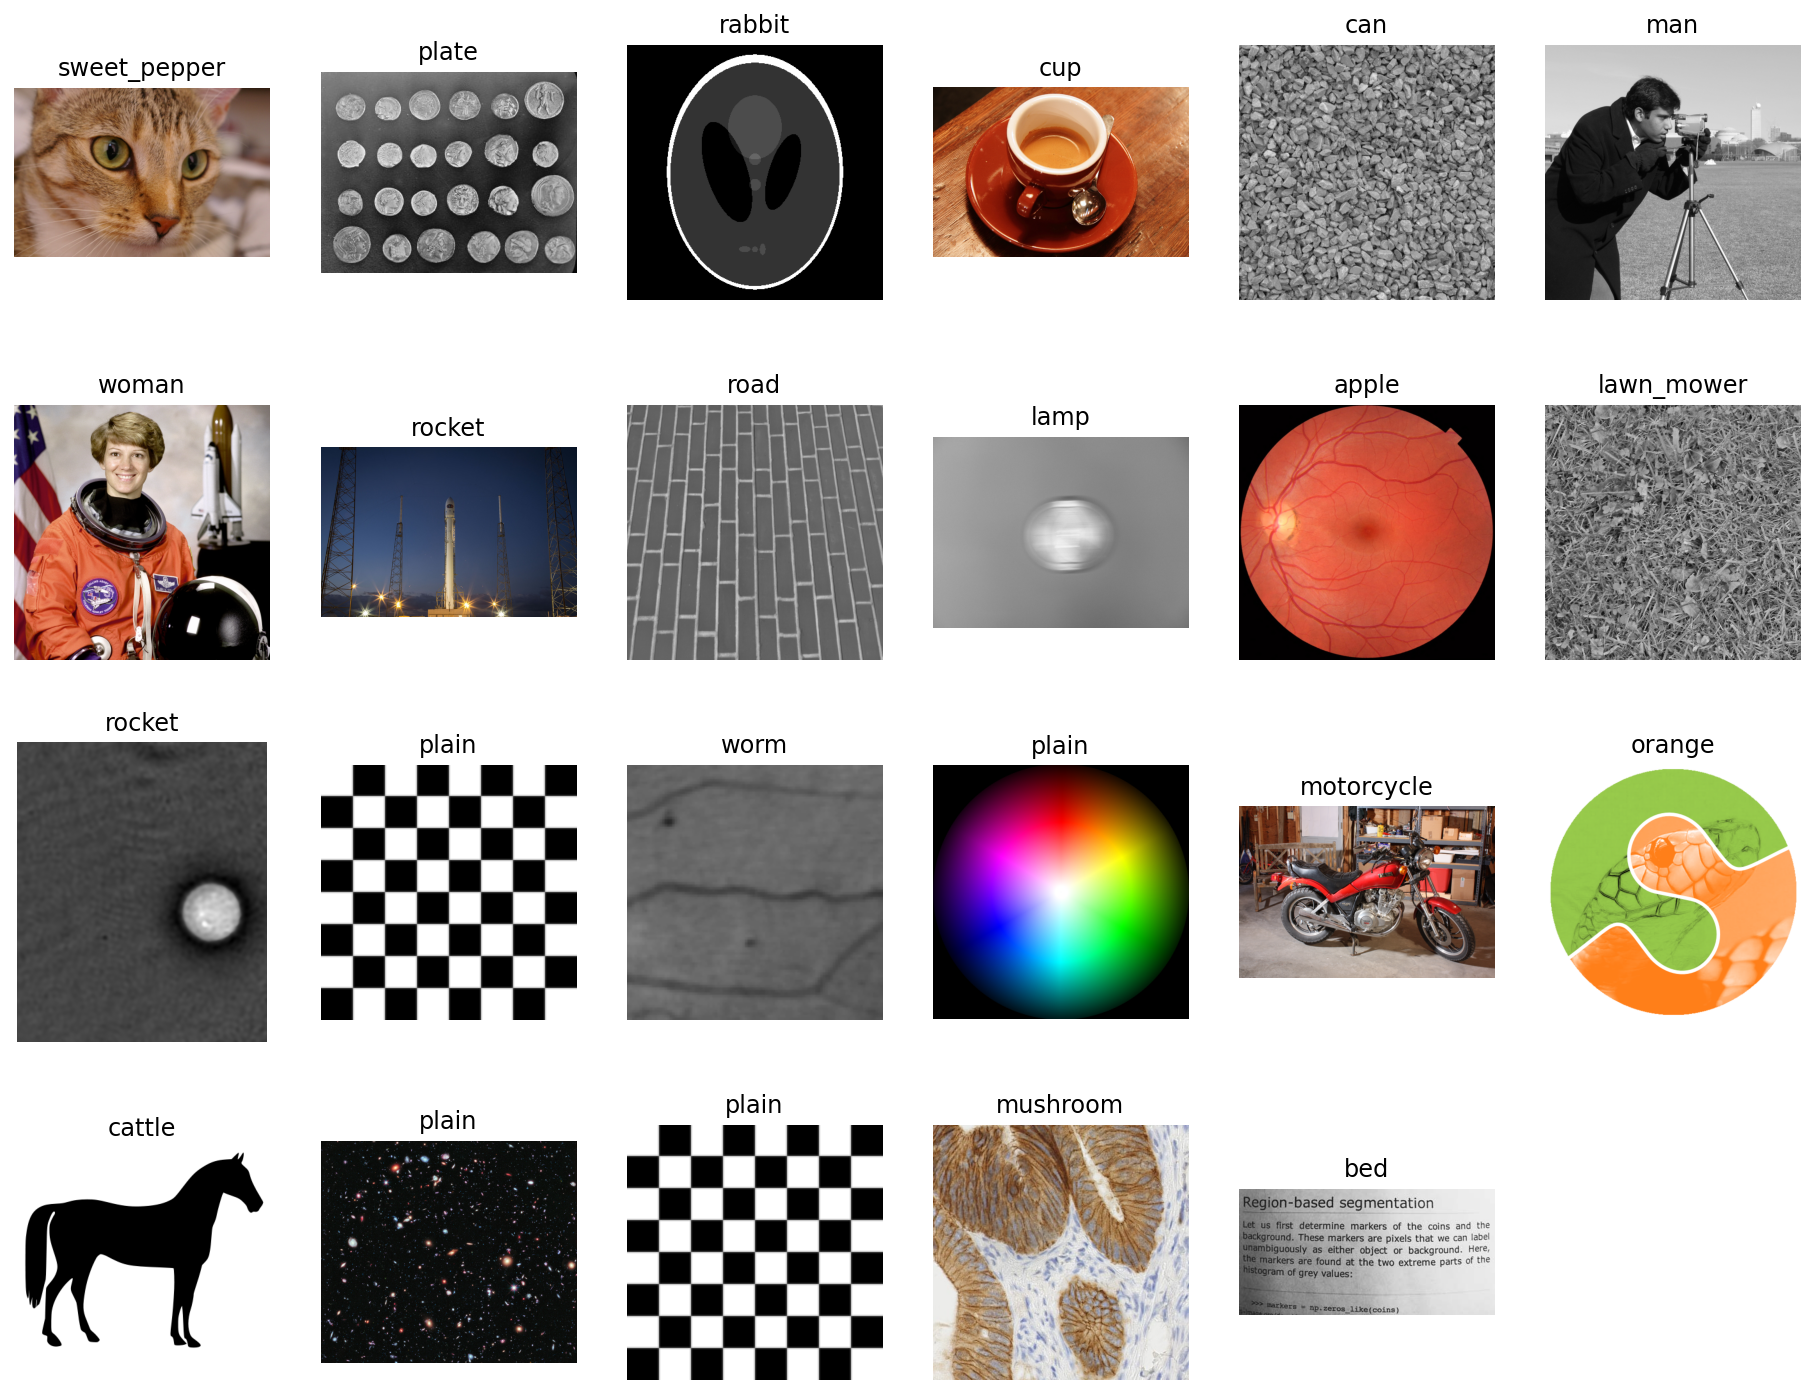

In [5]:
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

original_images = []
images = []
texts = []

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    
    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    original_images.append(image)
    images.append(preprocess(image))

plt.figure(figsize=(16, 16))

for i in range(len(original_images)-3):
    plt.subplot(5,6,i+1)
    image_input = torch.tensor(np.stack([images[i]])).cuda()
    _, similarity1 = model(image_input, text_tokens)
    plt.imshow(original_images[i])
    plt.axis("off")
    plt.title(cifar100.classes[similarity1.argmax(dim=0)[0].cpu().detach().numpy()])

plt.show()    